![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 3. Training and Reusing Named Entity Recognition Models

## Related blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.1.2
Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.5:7077 
 AppName 
 Databricks Shell

### CoNLL Data Prep

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [0]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
 Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
 BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
%time training_data.count()

CPU times: user 4.27 ms, sys: 0 ns, total: 4.27 ms
Wall time: 1.62 s
Out[6]: 14041

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
 token|pos|ner_label|
+----------+---+---------+
 EU|NNP| B-ORG|
 rejects|VBZ| O|
 German| JJ| B-MISC|
 call| NN| O|
 to| TO| O|
 boycott| VB| O|
 British| JJ| B-MISC|
 lamb| NN| O|
 .| .| O|
 Peter|NNP| B-PER|
 Blackburn|NNP| I-PER|
 BRUSSELS|NNP| B-LOC|
1996-08-22| CD| O|
 The| DT| O|
 European|NNP| B-ORG|
Commission|NNP| I-ORG|
 said|VBD| O|
 on| IN| O|
 Thursday|NNP| O|
 it|PRP| O|
+----------+---+---------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
ground_truth|count |
+------------+------+
O |169578|
B-LOC |7140 |
B-PER |6600 |
B-ORG |6321 |
I-PER |4528 |
I-ORG |3704 |
B-MISC |3438 |
I-LOC |1157 |
I-MISC |1155 |
+------------+------+

In [0]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

### Create Graph

We will use `TFNerDLGraphBuilder` annotator to create a graph in the model training pipeline. This annotator inspects the data and creates the proper graph if a suitable version of TensorFlow (<= 2.7 ) is available. The graph is stored in the defined folder and loaded by the approach.

**ATTENTION:** Do not forget to play with the parameters of this annotator, it may affect the model performance that you want to train.

**Licensed users** would use this module to create **custom graphs** for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP.

In [0]:
%fs mkdirs file:/dbfs/ner_logs

res0: Boolean = true

In [0]:
%fs mkdirs file:/dbfs/ner_graphs

res1: Boolean = true

In [0]:
graph_folder = "/dbfs/ner_graphs"

graph_builder = TFNerDLGraphBuilder()\
              .setInputCols(["sentence", "token", "embeddings"]) \
              .setLabelColumn("label")\
              .setGraphFile("auto")\
              .setGraphFolder(graph_folder)\
              .setHiddenUnitsNumber(20)

In [0]:
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setGraphFolder(graph_folder)\
              .setOutputLogsPath('dbfs:/ner_logs') # if not set, logs will be written to ~/annotator_logs
          #   .setEnableMemoryOptimizer(True) # if not set, logs will be written to ~/annotator_logs
    
ner_pipeline = Pipeline(stages=[glove_embeddings,
                                graph_builder,
                                nerTagger])


### Fitting

In [0]:
ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 1.5 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

/databricks/python/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
 warnings.warn(
Ner DL Graph Builder configuration:
Graph folder: /dbfs/ner_graphs
Graph file name: auto
Build params: {'ntags': 9, 'embeddings_dim': 100, 'nchars': 85, 'lstm_size': 20}
WARNING:tensorflow:From /databricks/python/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:111: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
WARNING:tensorflow:From /databricks/python/lib/python3.8/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
WARNING:tensorflow:From /databricks/python/lib/python3.8/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
WARNING:tensorflow:From /databricks/python/lib/python3.8/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/databricks/python/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
 warnings.warn('`layer.add_variable` is deprecated and '

In [0]:
%sh cd /dbfs/ner_logs && ls


NerDLApproach_439cb724c107.log
NerDLApproach_b8d98379503c.log

In [0]:
%sh head -n 45 /dbfs/ner_logs/NerDLApproach_*

==> /dbfs/ner_logs/NerDLApproach_439cb724c107.log <==
Name of the selected graph: /dbfs/ner_graphs/blstm_9_100_20_85.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11254


Epoch 1/3 started, lr: 0.003, dataset size: 11254


Epoch 1/3 - 23.47s - loss: 1799.9144 - batches: 353
Quality on validation dataset (20.0%), validation examples = 2250
time to finish evaluation: 2.29s
label tp fp fn prec rec f1
B-LOC 1135 152 264 0.8818959 0.8112938 0.8451229
I-ORG 552 316 161 0.6359447 0.7741935 0.69829226
I-MISC 42 9 210 0.8235294 0.16666667 0.27722773
I-LOC 46 1 170 0.9787234 0.21296297 0.34980989
I-PER 821 74 31 0.91731846 0.963615 0.93989694
B-MISC 390 28 302 0.93301433 0.5635838 0.7027027
B-ORG 1056 563 165 0.65225446 0.8648649 0.743662
B-PER 1137 164 88 0.87394315 0.9281633 0.90023756
tp: 5179 fp: 1307 fn: 1391 labels: 8
Macro-average prec: 0.83707803, rec: 0.660668, f1: 0.7384839
Micro-average prec: 0.79848903, rec: 0.78828007, f1: 0.7933517


Epoch 2/3 started, lr: 0.0029850747, dataset size: 11254


Epoch 2/3 - 20.93s - loss: 726.3985 - batches: 353
Quality on validation dataset (20.0%), validation examples = 2250
time to finish evaluation: 1.73s
label tp fp fn prec rec f1
B-LOC 1238 107 161 0.9204461 0.8849178 0.9023323
I-ORG 584 216 129 0.73 0.81907433 0.77197623
I-MISC 115 44 137 0.7232704 0.4563492 0.5596107
I-LOC 132 30 84 0.8148148 0.6111111 0.69841266
I-PER 814 29 38 0.96559906 0.95539904 0.960472
B-MISC 537 83 155 0.86612904 0.7760116 0.81859756
B-ORG 1075 296 146 0.7840992 0.8804259 0.82947534
B-PER 1132 73 93 0.9394191 0.9240816 0.93168724
tp: 5627 fp: 878 fn: 943 labels: 8
Macro-average prec: 0.8429722, rec: 0.78842133, f1: 0.81478477
Micro-average prec: 0.8650269, rec: 0.8564688, f1: 0.86072665


Epoch 3/3 started, lr: 0.0029702971, dataset size: 11254

==> /dbfs/ner_logs/NerDLApproach_b8d98379503c.log <==
Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 2 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11207


Epoch 1/2 started, lr: 0.003, dataset size: 11207


Epoch 1/2 - 30.92s - loss: 1474.4053 - batches: 354
Quality on validation dataset (20.0%), validation examples = 2241
time to finish evaluation: 2.65s
label tp fp fn prec rec f1
B-LOC 1315 147 115 0.8994528 0.9195804 0.9094053
I-ORG 600 139 164 0.811908 0.7853403 0.7984032
I-MISC 110 13 132 0.8943089 0.45454547 0.6027397
I-LOC 138 21 91 0.8679245 0.60262007 0.7113402
I-PER 931 46 13 0.9529171 0.9862288 0.96928686
B-MISC 547 51 191 0.9147157 0.7411924 0.81886226
B-ORG 1064 188 187 0.8498403 0.8505196 0.8501798
B-PER 1311 107 56 0.9245416 0.9590344 0.94147223
tp: 6016 fp: 712 fn: 949 labels: 8
Macro-average prec: 0.8894511, rec: 0.7873827, f1: 0.83531046
Micro-average prec: 0.8941736, rec: 0.8637473, f1: 0.87869716


Epoch 2/2 started, lr: 0.002857143, dataset size: 11207


Epoch 2/2 - 29.67s - loss: 448.14264 - batches: 354
Quality on validation dataset (20.0%), validation examples = 2241
time to finish evaluation: 2.27s
label tp fp fn prec rec f1
B-LOC 1353 119 77 0.9191576 0.9461538 0.93246037
I-ORG 659 123 105 0.842711 0.86256546 0.8525226
I-MISC 167 29 75 0.8520408 0.69008267 0.762557
I-LOC 173 23 56 0.88265306 0.75545853 0.8141176
I-PER 925 24 19 0.9747102 0.9798729 0.9772847
B-MISC 638 46 100 0.93274856 0.8644986 0.89732766
B-ORG 1116 151 135 0.8808208 0.8920863 0.8864178
B-PER 1308 53 59 0.961058 0.9568398 0.95894426
tp: 6339 fp: 568 fn: 626 labels: 8
Macro-average prec: 0.9057375, rec: 0.8684448, f1: 0.88669926
Micro-average prec: 0.9177646, rec: 0.91012204, f1: 0.9139274

In [0]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings| ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
 result| result| result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...| [O, O, B-ORG, O, O, O, O, O, O, O, O]| [O, O, B-ORG, O, O, O, O, O, O, O, O]|
 [LONDON, 1996-08-30]| [B-LOC, O]| [B-LOC, O]|
[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-LOC, I-LOC, O, B-PER, I-PER, O, O, O, O, O, ...|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows

### Test set evaluation

In [0]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
token |ground_truth|prediction|
+--------------+------------+----------+
CRICKET |O |O |
- |O |O |
LEICESTERSHIRE|B-ORG |B-ORG |
TAKE |O |O |
OVER |O |O |
AT |O |O |
TOP |O |O |
AFTER |O |O |
INNINGS |O |O |
VICTORY |O |O |
. |O |O |
LONDON |B-LOC |B-LOC |
1996-08-30 |O |O |
West |B-MISC |B-LOC |
Indian |I-MISC |I-LOC |
all-rounder |O |O |
Phil |B-PER |B-PER |
Simmons |I-PER |I-PER |
took |O |O |
four |O |O |
+--------------+------------+----------+
only showing top 20 rows

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearen.mnetrics or any other equivalent module to do the same.

In [0]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


precision recall f1-score support

 B-LOC 0.89 0.94 0.91 1837
 B-MISC 0.93 0.76 0.84 922
 B-ORG 0.82 0.84 0.83 1341
 B-PER 0.95 0.94 0.95 1842
 I-LOC 0.74 0.70 0.72 257
 I-MISC 0.88 0.46 0.60 346
 I-ORG 0.76 0.78 0.77 751
 I-PER 0.96 0.96 0.96 1307
 O 0.99 1.00 0.99 42759

 accuracy 0.98 51362
 macro avg 0.88 0.82 0.84 51362
weighted avg 0.97 0.98 0.97 51362

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py
  
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/databricks/driver/')
#sys.path.append('/databricks/driver/databricks_import_python_module/')
sys.path.append('/databricks/driver/conll_eval.py')

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 51362 tokens with 5942 phrases; found: 5885 phrases; correct: 5194.
accuracy: 86.87%; (non-O)
accuracy: 97.51%; precision: 88.26%; recall: 87.41%; FB1: 87.83
 LOC: precision: 88.72%; recall: 93.74%; FB1: 91.16 1941
 MISC: precision: 90.12%; recall: 73.21%; FB1: 80.79 749
 ORG: precision: 78.65%; recall: 79.94%; FB1: 79.29 1363
 PER: precision: 94.16%; recall: 93.65%; FB1: 93.90 1832

In [0]:
# micro, macro, avg
metrics[0]

Out[22]: (88.25828377230246, 87.41164591046785, 87.83292466390463)

In [0]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[23]:

,entity,precision,recall,f1,support
0,LOC,88.717156,93.739793,91.159344,1941
1,MISC,90.120160,73.210412,80.789946,749
2,ORG,78.650037,79.940343,79.289941,1363
3,PER,94.159389,93.648208,93.903103,1832


### Splitting dataset into train and test

Also we will use .setTestDataset('ner_dl_test.parquet') for checking test-loss values of each epoch in the logs file and .useBestModel(True) parameter whether to restore and use the model that has achieved the best performance at the end of the training. .

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9739
Test Dataset Count: 4302

Let's save our `test_data` as parquet by transforming with embeddings.

In [0]:
glove_embeddings.transform(test_data).write.mode("overwrite").parquet('dbfs/nerdl_test.parquet')

In [0]:
%fs mkdirs file:/dbfs/ner_logs_best

res2: Boolean = true

Let's use `setUseBestModel(True)` parameter to restore the model with the best performance at the end of the training and use the `setTestDataset` parameter to calculate statistical measures for each epoch during training

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(5)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setUseBestModel(True)\
  .setGraphFolder(graph_folder)\
  .setTestDataset('dbfs:/nerdl_test.parquet')\
  .setOutputLogsPath('dbfs:/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          graph_builder,
          nerTagger
 ])

In [0]:
%%time
ner_model = ner_pipeline.fit(training_data)

Ner DL Graph Builder configuration:
Graph folder: /dbfs/ner_graphs
Graph file name: auto
Build params: {'ntags': 9, 'embeddings_dim': 100, 'nchars': 85, 'lstm_size': 20}
/databricks/python/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
 warnings.warn('`layer.add_variable` is deprecated and '
CPU times: user 5.32 s, sys: 410 ms, total: 5.73 s
Wall time: 2min 9s

In [0]:
%sh cat /dbfs/ner_logs_best/NerDLApproach_*.log

Name of the selected graph: /dbfs/ner_graphs/blstm_9_100_20_85.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 82 - training examples: 7800


Epoch 1/5 started, lr: 0.003, dataset size: 7800


Epoch 1/5 - 16.21s - loss: 1653.8295 - batches: 246
Quality on validation dataset (20.0%), validation examples = 1560
time to finish evaluation: 1.67s
label tp fp fn prec rec f1
B-LOC 807 236 178 0.7737296 0.8192893 0.79585797
I-ORG 309 149 176 0.6746725 0.6371134 0.6553552
I-MISC 24 5 141 0.82758623 0.14545454 0.24742268
I-LOC 3 2 180 0.6 0.016393442 0.031914894
I-PER 561 96 24 0.8538813 0.95897436 0.90338165
B-MISC 320 83 156 0.7940447 0.6722689 0.7281001
B-ORG 652 270 234 0.7071583 0.73589164 0.7212389
B-PER 801 137 77 0.85394454 0.9123007 0.88215864
tp: 3477 fp: 978 fn: 1166 labels: 8
Macro-average prec: 0.76062715, rec: 0.6122108, f1: 0.6783964
Micro-average prec: 0.7804714, rec: 0.74886924, f1: 0.76434374
Quality on test dataset: 
time to finish evaluation: 2.69s
label tp fp fn prec rec f1
B-LOC 1733 558 426 0.75643826 0.80268645 0.7788764
I-ORG 762 287 385 0.7264061 0.66434175 0.6939891
I-MISC 54 14 325 0.7941176 0.14248021 0.24161074
I-LOC 8 17 341 0.32 0.022922637 0.04278075
I-PER 1382 156 64 0.8985696 0.95574 0.92627347
B-MISC 706 222 341 0.76077586 0.6743075 0.71493673
B-ORG 1397 586 529 0.70448816 0.7253375 0.71476084
B-PER 1885 249 157 0.8833177 0.9231146 0.9027778
tp: 7927 fp: 2089 fn: 2568 labels: 8
Macro-average prec: 0.73051417, rec: 0.6138663, f1: 0.66712964
Micro-average prec: 0.7914337, rec: 0.755312, f1: 0.77295107


Epoch 2/5 started, lr: 0.0029850747, dataset size: 7800


Epoch 2/5 - 14.26s - loss: 654.60254 - batches: 246
Quality on validation dataset (20.0%), validation examples = 1560
time to finish evaluation: 1.23s
label tp fp fn prec rec f1
B-LOC 910 218 75 0.8067376 0.92385787 0.8613346
I-ORG 365 138 120 0.72564614 0.7525773 0.7388664
I-MISC 54 19 111 0.739726 0.3272727 0.4537815
I-LOC 98 36 85 0.73134327 0.5355191 0.6182965
I-PER 556 36 29 0.9391892 0.95042735 0.9447749
B-MISC 351 69 125 0.8357143 0.7373949 0.78348213
B-ORG 713 211 173 0.771645 0.8047404 0.7878453
B-PER 793 61 85 0.9285714 0.90318906 0.9157044
tp: 3840 fp: 788 fn: 803 labels: 8
Macro-average prec: 0.8098216, rec: 0.7418724, f1: 0.7743593
Micro-average prec: 0.82973206, rec: 0.82705146, f1: 0.8283896
Quality on test dataset: 
time to finish evaluation: 2.72s
label tp fp fn prec rec f1
B-LOC 1962 522 197 0.78985506 0.90875405 0.8451432
I-ORG 863 291 284 0.7478336 0.75239754 0.7501086
I-MISC 150 45 229 0.7692308 0.39577836 0.5226481
I-LOC 186 71 163 0.7237354 0.5329513 0.6138614
I-PER 1374 53 72 0.96285915 0.9502075 0.9564915
B-MISC 780 185 267 0.8082902 0.7449857 0.77534795
B-ORG 1484 479 442 0.75598574 0.7705088 0.76317817
B-PER 1869 107 173 0.9458502 0.91527915 0.9303136
tp: 8668 fp: 1753 fn: 1827 labels: 8
Macro-average prec: 0.812955, rec: 0.7463578, f1: 0.77823424
Micro-average prec: 0.831782, rec: 0.8259171, f1: 0.8288392


Epoch 3/5 started, lr: 0.0029702971, dataset size: 7800


Epoch 3/5 - 14.76s - loss: 477.7551 - batches: 246
Quality on validation dataset (20.0%), validation examples = 1560
time to finish evaluation: 1.24s
label tp fp fn prec rec f1
B-LOC 898 135 87 0.8693127 0.91167516 0.8899901
I-ORG 392 145 93 0.72998136 0.80824745 0.76712334
I-MISC 56 17 109 0.7671233 0.33939394 0.47058824
I-LOC 113 36 70 0.75838923 0.61748636 0.6807229
I-PER 564 32 21 0.94630873 0.96410257 0.95512277
B-MISC 355 53 121 0.87009805 0.7457983 0.8031674
B-ORG 770 211 116 0.78491336 0.86907446 0.82485265
B-PER 811 58 67 0.9332566 0.9236902 0.92844874
tp: 3959 fp: 687 fn: 684 labels: 8
Macro-average prec: 0.832423, rec: 0.7724335, f1: 0.8013071
Micro-average prec: 0.8521309, rec: 0.85268146, f1: 0.85240614
Quality on test dataset: 
time to finish evaluation: 2.76s
label tp fp fn prec rec f1
B-LOC 1935 281 224 0.87319493 0.8962483 0.8845714
I-ORG 925 294 222 0.7588187 0.8064516 0.7819104
I-MISC 167 36 212 0.8226

In [0]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


precision recall f1-score support

 B-LOC 0.9357 0.8833 0.9087 2159
 B-MISC 0.9365 0.7889 0.8564 1047
 B-ORG 0.7652 0.8951 0.8251 1926
 B-PER 0.9615 0.9300 0.9455 2042
 I-LOC 0.8740 0.6562 0.7496 349
 I-MISC 0.8945 0.5594 0.6883 379
 I-ORG 0.7336 0.8788 0.7997 1147
 I-PER 0.9747 0.9606 0.9676 1446
 O 0.9938 0.9948 0.9943 52122

 accuracy 0.9749 62617
 macro avg 0.8966 0.8386 0.8595 62617
weighted avg 0.9763 0.9749 0.9749 62617

### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py
  
sys.path.append('/databricks/driver/ner_log_parser.py')

In [0]:
import ner_log_parser

In [0]:
%matplotlib inline

In [0]:
%sh cd /dbfs/ner_logs_best && pwd && ls -l

/dbfs/ner_logs_best
total 24
-rwxrwxrwx 1 root root 7813 Jan 18 23:09 NerDLApproach_8b490c58d992.log
-rwxrwxrwx 1 root root 7830 Oct 11 09:58 NerDLApproach_d6dee82e3eae.log
-rwxrwxrwx 1 root root 7797 Jan 8 18:14 NerDLApproach_f4978ec2d7c6.log

In [0]:
import os
log_files = os.listdir("/dbfs/ner_logs_best/")
log_files

Out[34]: ['NerDLApproach_8b490c58d992.log',
 'NerDLApproach_d6dee82e3eae.log',
 'NerDLApproach_f4978ec2d7c6.log']

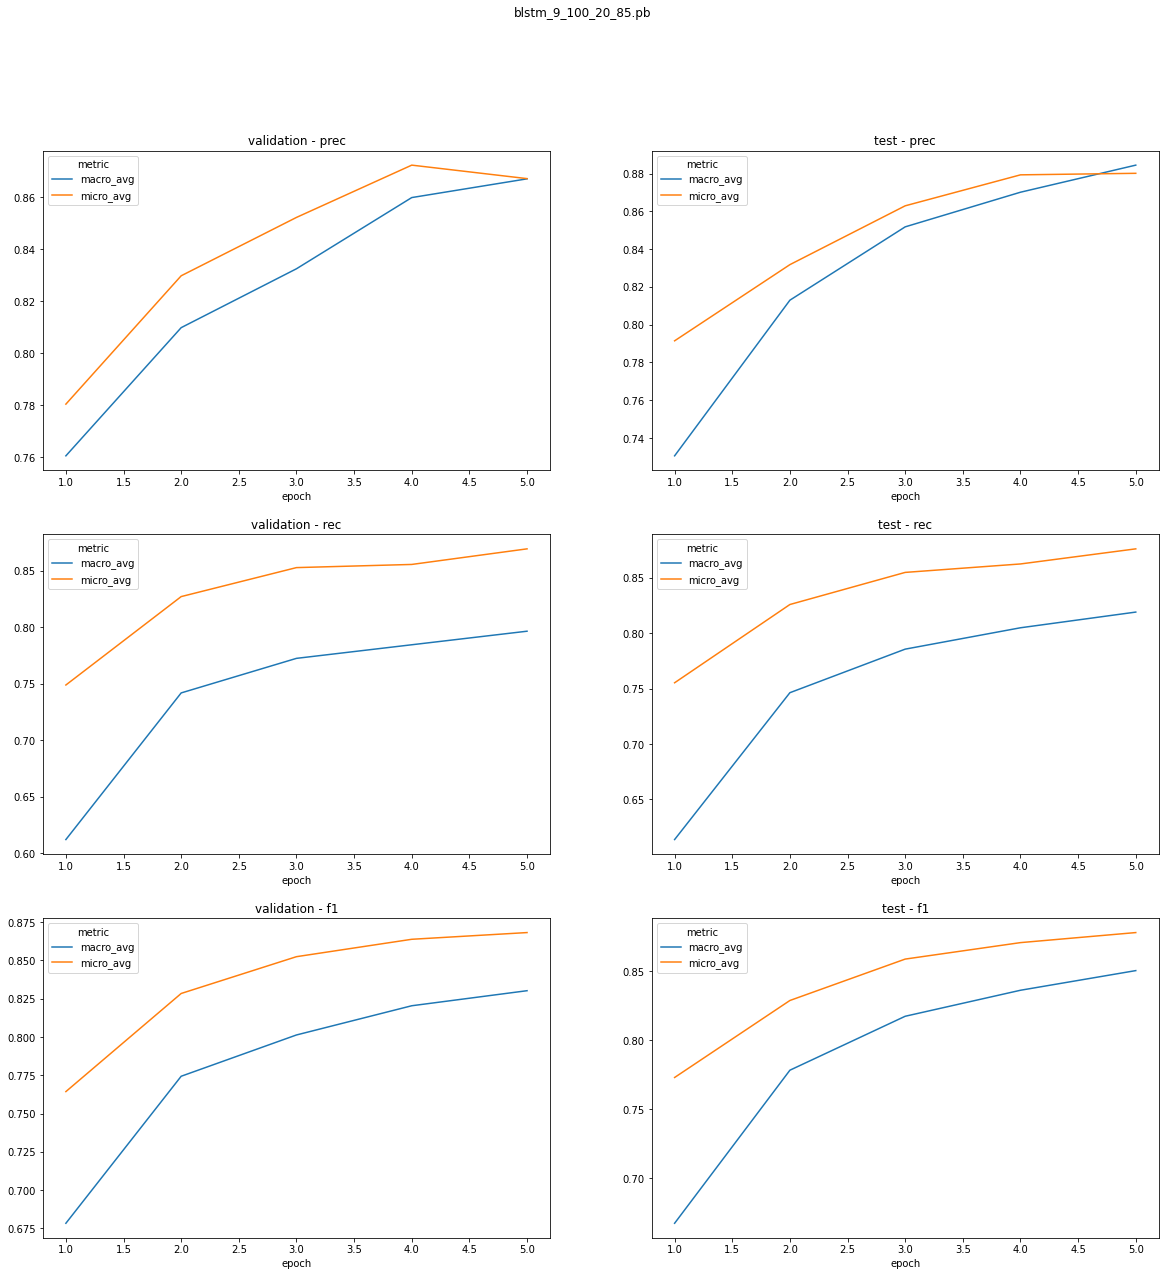

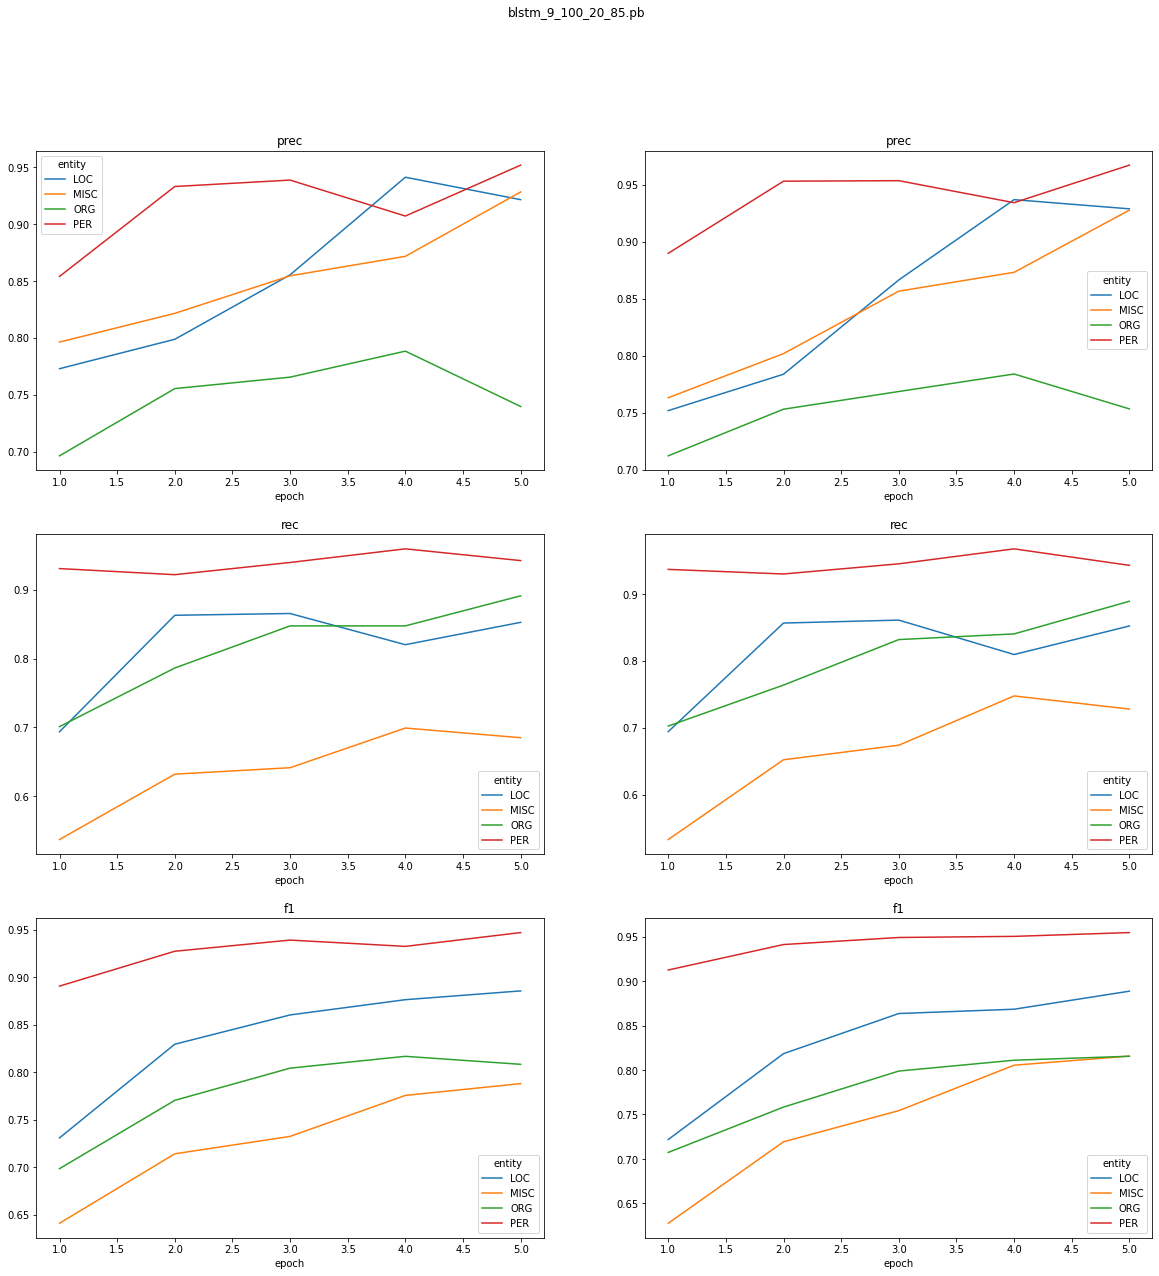

In [0]:
ner_log_parser.get_charts('/dbfs/ner_logs_best/'+log_files[0])

**Plotting Loss**

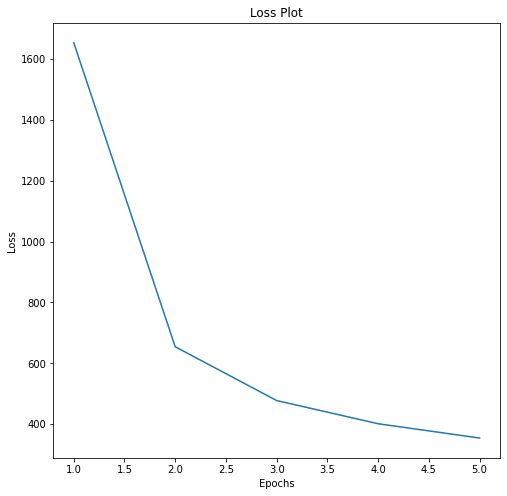

In [0]:
ner_log_parser.loss_plot('/dbfs/ner_logs_best/'+log_files[0])

### Saving the trained model

In [0]:
ner_model.stages

Out[37]: [WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 TFNerDLGraphBuilderModel_39a10902b69b,
 NerDLModel_0765a6efb74a]

In [0]:
%sh cd /databricks/driver/ && ls -la

total 331132
drwxr-xr-x 1 root root 4096 Jan 18 23:10 .
drwxr-xr-x 1 root root 4096 Jan 18 19:27 ..
drwxr-xr-x 2 root root 4096 Jan 18 23:10 __pycache__
-rw-r--r-- 1 root root 32715164 May 2 2020 aclimdb_test.csv
-rw-r--r-- 1 root root 32715164 May 2 2020 aclimdb_test.csv.1
-rw-r--r-- 1 root root 33497180 May 2 2020 aclimdb_train.csv
-rw-r--r-- 1 root root 33497180 May 2 2020 aclimdb_train.csv.1
drwxr-xr-x 2 root root 4096 Jan 18 19:25 conf
-rw-r--r-- 1 root root 7431 Jan 18 23:07 conll_eval.py
-rw-r--r-- 1 root root 827443 Jan 18 23:05 eng.testa
-rw-r--r-- 1 root root 3283420 Jan 18 23:05 eng.train
drwxr-xr-x 3 root root 4096 Jan 18 19:27 eventlogs
drwxr-xr-x 2 root root 4096 Jan 18 23:00 ganglia
drwxr-xr-x 2 root root 4096 Jan 18 23:01 logs
-rw-r--r-- 1 root root 105074090 Jan 18 23:04 my_nlp_pipeline.zip
-rw-r--r-- 1 root root 3826 Jan 18 23:10 ner_log_parser.py
-rw-r--r-- 1 root root 1504408 Jan 18 19:37 news_category_test.csv
-rw-r--r-- 1 root root 1504408 Jan 18 20:16 news_category_test.csv.1
-rw-r--r-- 1 root root 1504408 Jan 18 21:20 news_category_test.csv.2
-rw-r--r-- 1 root root 24032125 Jan 18 19:37 news_category_train.csv
-rw-r--r-- 1 root root 24032125 Jan 18 20:16 news_category_train.csv.1
-rw-r--r-- 1 root root 24032125 Jan 18 21:20 news_category_train.csv.2
-r-xr-xr-x 1 root root 813069 Jan 18 19:25 preload_class.lst
-rw-r--r-- 1 root root 5502589 Jan 18 19:36 spam_ham_dataset.csv
-rw-r--r-- 1 root root 5502589 Jan 18 20:15 spam_ham_dataset.csv.1
-rw-r--r-- 1 root root 5502589 Jan 18 21:19 spam_ham_dataset.csv.2
-rw-r--r-- 1 root root 188402 Jan 18 20:06 title_conference.csv
-rw-r--r-- 1 root root 188402 Jan 18 20:44 title_conference.csv.1
-rw-r--r-- 1 root root 296833 Jan 18 22:13 toxic_test.snappy.parquet
-rw-r--r-- 1 root root 2767307 Jan 18 22:13 toxic_train.snappy.parquet

In [0]:
ner_model.stages[-1].write().overwrite().save('dbfs:/databricks/driver/models/NerDLModel_5e32b')

## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")
    
loaded_ner_model = NerDLModel.load("dbfs:/databricks/driver/models/NerDLModel_5e32b")\
     .setInputCols(["sentence", "token", "embeddings"])\
     .setOutputCol("ner")

converter = NerConverter()\
      .setInputCols(["document", "token", "ner"])\
      .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [0]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
text |
+-------------------------------------------------+
Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+

In [0]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
chunk |entity|
+------------+------+
Peter Parker|PER |
New York |LOC |
+------------+------+

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

Out[45]: [('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

Out[46]:

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


# Creating your own CoNLL dataset

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb

In [0]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')
    
    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline()



pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ][ / ][ — ][OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[ | ][ / ][ — ][OK!]
Spark NLP NER lightpipeline is created

In [0]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O

End of Notebook #